In [2]:
import datetime
import math
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
comments = pd.read_csv("/usr/src/app/data/ka-comments.csv")

print "Total size: %d" % len(comments)

print comments[:10]

Total size: 1145440
                  video                                        id  \
0  ancient-temples-nara  33ae6dffe9efdf1bba47412945f3f96ee85e39f7   
1  ancient-temples-nara  ea997873e7cd069c8a6bf2f14809950ac237001c   
2  ancient-temples-nara  61b80f281d1ac24d102535496ad3a963e226cdeb   
3  ancient-temples-nara  49349c01d95f512a04da8f32d54e4aa22d7ec8a9   
4  ancient-temples-nara  847d456003e470c236375a5195d87dc94b46cfc1   
5  ancient-temples-nara  348392e7888687e821de048609cace4a08da4e18   
6  ancient-temples-nara  58f2adc07ebca4285963c55b2736449f900458bd   
7  ancient-temples-nara  96ca02013d5c2bfe8a1bc29932764a3484d47979   
8  ancient-temples-nara  a0c8b56cac318667d2a8aa124b63ff1d00f97fb0   
9  ancient-temples-nara  dac041cb6faff46c806323837292d153b478c4b6   

                                             content  \
0  Why does the pagoda have 5 stories? Wouldn't t...   
1  5 stories represent  5 elements make up our wo...   
2  Because it's easier to calculate the middle wi...

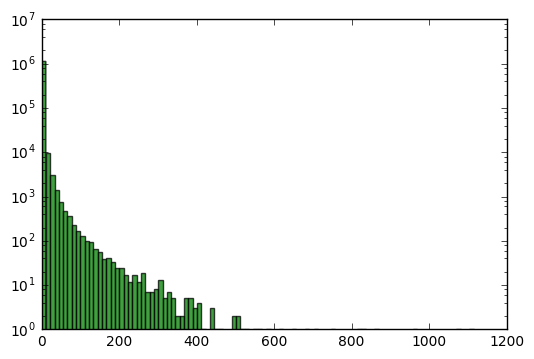

In [4]:
plt.hist(comments["sumVotesIncremented"], 100, facecolor='green', log=True, alpha=0.75)
plt.show()

In [5]:
# Turn `sumVotesIncremented` into a binary variable
comments["hasVotes"] = comments["sumVotesIncremented"] > 1

# Parse datetimes
comments["date"] = np.array(comments["date"], dtype="datetime64")

# Convert date into number of days "ago" (meaning, before we scraped the dataset)
comments["daysAgo"] = pd.Series((comments["date"] - max(comments["date"])).astype('timedelta64[D]'))

def calc_comment_counts(comments):
    counts = comments.groupby("video", as_index=False).count()
    counts = pd.DataFrame({
        "video": counts["video"],
        "totalComments": counts["id"],
    })
    return comments.merge(counts)
    
comments = calc_comment_counts(comments)

def rel_rank(df):
    df['relRank'] = (np.arange(len(df)) + 1).astype(float) / len(df)
    return df

comments = (comments
    .sort(["sumVotesIncremented", "daysAgo"], ascending=False)
    .groupby("video", as_index=False)
    .apply(rel_rank))
    
comments["topRank"] = comments["relRank"] < 0.2
comments["bottomRank"] = comments["relRank"] > 0.8

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:5: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:25: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


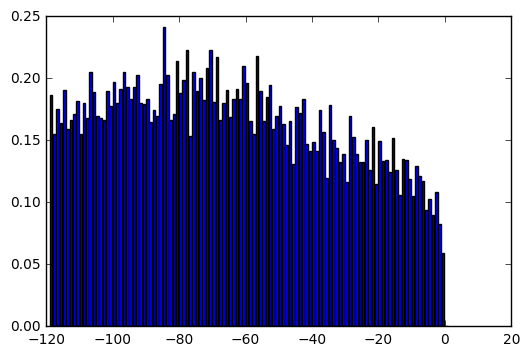

In [44]:
def has_votes_by_date():
    dataframe = pd.DataFrame({
        "daysAgo": comments["daysAgo"],
        "hasVotes": comments["hasVotes"].astype('int'),
    })
    votes_by_date = dataframe[dataframe["daysAgo"] > -120].groupby("daysAgo", as_index=False).mean()
    plt.bar(votes_by_date["daysAgo"], votes_by_date["hasVotes"])
    plt.show()
    
has_votes_by_date()

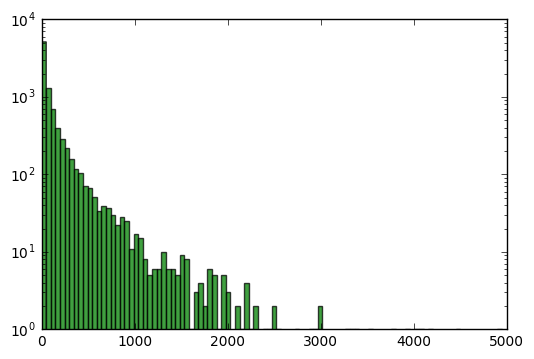

In [45]:
def video_comment_count():
    counts = comments.groupby("video", as_index=False).count()
    plt.hist(counts["id"], 100, facecolor='green', log=True, alpha=0.75)
    plt.show()
    
video_comment_count()

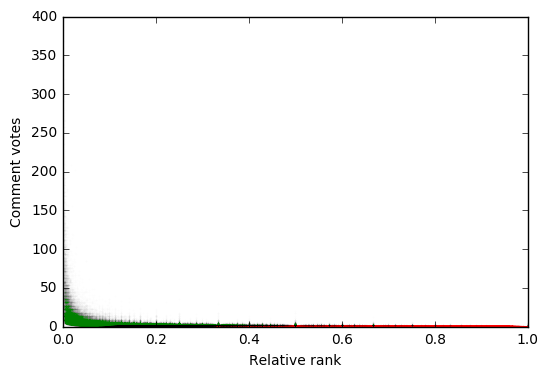

In [46]:
def comment_rankings():
    comments1 = comments[comments["hasVotes"] == True]
    comments2 = comments[comments["hasVotes"] == False]
    plt.scatter(comments2["relRank"], comments2["sumVotesIncremented"], s=1, alpha=0.003, color='red')
    plt.scatter(comments1["relRank"], comments1["sumVotesIncremented"], s=1, alpha=0.003, color='green')
    plt.xlabel("Relative rank")
    plt.ylabel("Comment votes")
    axes = plt.gca()
    axes.set_xlim([0,1])
    axes.set_ylim([0,400])
    plt.show()
    
comment_rankings()

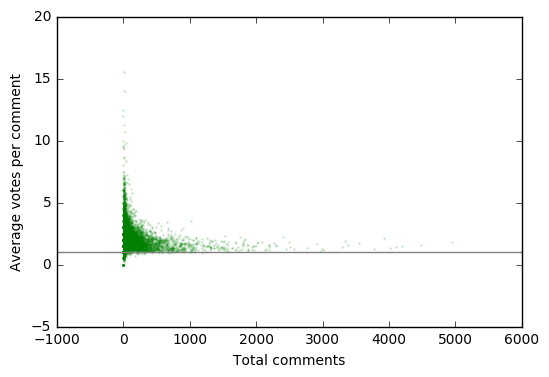

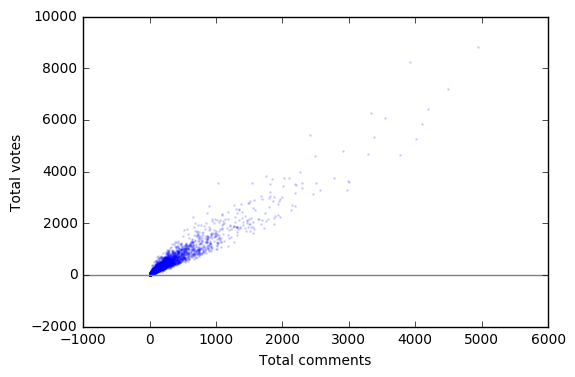

In [47]:
def votes_vs_comments():
    groups = pd.DataFrame({
        "video": comments["video"],
        "sumVotesIncremented": comments["sumVotesIncremented"],
    }).groupby("video", as_index=False)
    
    mean_votes = groups.mean()["sumVotesIncremented"]
    sum_votes = groups.sum()["sumVotesIncremented"]
    num_comments = groups.count()["sumVotesIncremented"]
    plt.scatter(num_comments, mean_votes, s=1, alpha=0.125, color='green')
    plt.axhline(1, color='gray')
    plt.xlabel("Total comments")
    plt.ylabel("Average votes per comment")
    plt.show()
    
    plt.scatter(num_comments, sum_votes, s=1, alpha=0.125, color='blue')
    plt.axhline(1, color='gray')
    plt.xlabel("Total comments")
    plt.ylabel("Total votes")
    plt.show()
    
votes_vs_comments()

In [56]:
def transform_scores(data, column, dataset_name):
    data["label"] = data[column]
    
    # Count positives
    positive_count = np.sum(data["label"])
    print "%d / %d comments with positive label" % (positive_count, len(data))

    # Generate a balanced set, interleaved TFTF... so we can easily
    # create balanced training/test sets by taking slices
    positive_indices = np.where(data["label"] == True)[0]
    negative_indices = np.where(data["label"] == False)[0]
    balanced_indices = [
        val
        for pair in zip(positive_indices, negative_indices[:len(positive_indices)])
        for val in pair]
    print "%d balanced indices" % len(balanced_indices)

    balanced_dataset = data.iloc[balanced_indices]

    validate_size = 5000
    test_size = 5000
    train_size = len(balanced_dataset) - validate_size - test_size
    print "%s: Training set %d, Validate set %d, Test set %d" % (
        dataset_name, train_size, validate_size, test_size)

    dataset = {
        "train_data": balanced_dataset.iloc[:train_size],
        "validate_data": balanced_dataset.iloc[train_size:train_size+validate_size],
        "test_data": balanced_dataset.iloc[train_size+validate_size:train_size+validate_size+test_size],
    }

    with open("/usr/src/app/data/%s.pickle" % dataset_name, "wb") as f:
        pickle.dump(dataset, f)
        
    print "Done."
        
    return dataset

In [57]:
_ = transform_scores(comments[comments["daysAgo"] < -50], "hasVotes", "ka-comments-balanced")

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


249120 / 1102972 comments with positive label
498240 balanced indices
ka-comments-balanced: Training set 488240, Validate set 5000, Test set 5000
Done.


In [59]:
def get_replies(comments):
    replies = comments[comments["replyTo"].astype(str) != "nan"]
    replies_joined = pd.merge(replies, comments, how="left", left_on=["replyTo"], right_on=["id"],
                              suffixes=("", "_parent"))
    return replies_joined

_ = transform_scores(get_replies(comments[comments["daysAgo"] < -50]), "hasVotes", "ka-replies-balanced")

159108 / 575025 comments with positive label
318216 balanced indices
ka-replies-balanced: Training set 308216, Validate set 5000, Test set 5000
Done.


In [63]:
_ = transform_scores(
    comments[(comments["daysAgo"] < -50) & (comments["totalComments"] > 2)],
    "topRank", "ka-rank-balanced")

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


208564 / 1102457 comments with positive label
417128 balanced indices
ka-rank-balanced: Training set 407128, Validate set 5000, Test set 5000
Done.


In [15]:
SAMPLING_RATE = 500

def rank_ordering(comments):
    groups = (comments
        .sort(["sumVotesIncremented", "daysAgo"], ascending=False)
        .groupby("video", as_index=False))
    
    content_left = []
    content_right = []
    label = []
    index = 0
    cnt = 0
    for video, group in groups:
        group_size = np.shape(group)[0]
        for i in xrange(group_size):
            for j in xrange(i+1, group_size):
                index += 1
                if (index % (SAMPLING_RATE*2)) == 0:
                    content_left.append(group["content"].iloc[i])
                    content_right.append(group["content"].iloc[j])
                    label.append(True)
                elif (index % (SAMPLING_RATE*2)) == SAMPLING_RATE:
                    content_left.append(group["content"].iloc[j])
                    content_right.append(group["content"].iloc[i])
                    label.append(False)
        cnt += 1
        if (cnt % 250) == 0:
            print "%s - %d" % (video, len(content_left))
                    
    print "Generated %d rows." % len(content_left)
    df = pd.DataFrame({
        "content_left": content_left,
        "content_right": content_right,
        "label": label
    })
    
    print "Shuffling..."
    df.reindex(np.random.permutation(df.index))
    
    validate_size = 5000
    test_size = 5000
    train_size = len(df) - validate_size - test_size
    print "ka-binary: Training set %d, Validate set %d, Test set %d" % (
        train_size, validate_size, test_size)

    dataset = {
        "train_data": df.iloc[:train_size],
        "validate_data": df.iloc[train_size:train_size+validate_size],
        "test_data": df.iloc[train_size+validate_size:train_size+validate_size+test_size],
    }

    with open("/usr/src/app/data/ka-binary.pickle", "wb") as f:
        pickle.dump(dataset, f)
        
    print "Done."
        
rank_ordering(comments)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:5: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


acute-treatment-of-stroke-with-medications - 15197
andrea-pisano-reliefs-for-the-florence-campanile-c-1336 - 70191
atp-hydrolysis - 88699
bhp-why-civilizations-expand - 138913
cahsee-practice-problems-23-27 - 170302
chem34-network-solids-carbon - 181819
comparing-proportional-relationships-exercise-2 - 207095
corporate-debt-versus-traditional-mortgages - 217341
decay-of-cesium-137-example - 230830
disguised-derivatives - 246105
ee-ideal-sources - 272537
eternity - 315892
federal-reserve-balance-sheet - 334055
frequency-table-independent-events - 350248
gmat-math-41 - 352591
hohlwein-kaffee-hag - 364938
inequalities-in-one-variable-1-exercise - 371308
introduction-to-the-black-scholes-formula - 443660
laplace-transform-2 - 465397
linking-function-of-the-colon-the-colon-and-semicolon-punctuation-khan-academy - 487588
mean-absolute-deviation-example - 494495
more-examples-finding-vector-angles - 507362
nicola-and-giovanni-pisano-1260-1301 - 560824
palace-westminster - 586566
placenta-accr